# IMPORTS

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from scipy import optimize
import pickle

import sys 
sys.path.append("C:\\Work\\Fast-Navier-Stokes") #tell where to look for package
#import MyPackages.periodicnumerics as num
#from importlib import reload
#reload(num) #make sure any changes have been loaded in, useful if modifying while running

#random number gen
rng = np.random.default_rng()

# CODE

## NUMERICS DISCRETIZATIONS

In [3]:
@jit(nopython = True)
def centerize(u,v): #get cell-center values from cell-face values for x and y components of a vector (assumed a velocity)
    return (u[1:] + u[:-1])/2, (v[:,1:] + v[:,:-1])/2

@jit(nopython = True)
def xdivc(u): #calculate x derivative of cell-center defined gradient field, center diff
    dudx = np.zeros((Nx,Ny)) #initialize return array
    
    dudx[1:-1] = (u[2:] - u[:-2])/(2*dx) #fill in non-edge values
    dudx[0] = (u[1] - u[0])/dx #left edge (assume consistent gradient at bnd)
    dudx[-1] = (u[-1] - u[-2])/dx #right edge (assume consistent gradient at bnd)
    
    return dudx

@jit(nopython = True)
def ydivc(u): #calculate y derivative of cell-center defined gradient field, center diff
    dudy = np.zeros((Nx,Ny)) #initialize return array
    
    dudy[:,1:-1] = (u[:,2:] - u[:,:-2])/(2*dy) #fill in non-edge values
    dudy[:,0] = (u[:,1] - u[:,0])/dy #bottom edge (assume consistent gradient at bnd)
    dudy[:,-1] = (u[:,-1] - u[:,-2])/dy #top edge (assume consistent gradient at bnd)
    
    return dudy

@jit(nopython = True)
def get_div(u,v,dx,dy): #calculate approximate divergence of velocity field. #input velocities defined at cell bnds, return divergences at cell centers. #x velocity (u), y velocity (v)
    dudx, dvdy = (u[1:] - u[:-1])/dx, (v[:,1:] - v[:,:-1])/dy #velocity gradient components
    return dudx + dvdy

## PDE FUNCTIONS

In [4]:
#@jit(nopython=True)
def ViscForces(u_c, v_c): #calculate x and y components of viscous forces at cell centers #input cell-center values of velocities
    Fvisc_x, Fvisc_y = np.zeros((Nx,Ny)), np.zeros((Nx,Ny)) #placeholder
    return Fvisc_x, Fvisc_y

#@jit(nopython=True)
def DragForces(u_c, v_c): #calculate x and y components of a simple square-law drag (imagine plates above and below the 2-D plane) at cell centers #input cell-center values of velocities
    mag_c = np.sqrt(u_c**2 + v_c**2) #velocity vector magnitude
    return -C_D*u_c*mag_c, -C_D*v_c*mag_c #drag force density components. in opposition to direction of velocity, with vel*2 as magnitude

#@jit(nopython=True)
def OneStepIterateFNS(u, v, dudt_pre, dvdt_pre, delP_x, delP_y): #iterate time derivatives of the velocities
    u_c, v_c = centerize(u, v) #get cell-center averages of the velocities
    
    ddx_dudt, ddy_dvdt = (dudt_pre[1:] - dudt_pre[:-1])/dx, (dvdt_pre[:,1:] - dvdt_pre[:,:-1])/dy #get x div of previous iteration dudt's, y div of dvdt's at cell centers
    dDdt_x, dDdt_y =  -np.cumsum(ddy_dvdt, axis=0)*dx, -np.cumsum(ddx_dudt, axis=1)*dy #point to point deltas along x (for u) lines and y (for v) lines respectively. From divergence = 0 formula.

    #print(u[-1])
    #print(u[0])
    adv_x_x, adv_y_y = (u[-1]**2 - u[0]**2)/2, (v[:,-1]**2 - v[:,0]**2)/2 #self-advection (integrated over channel)
    #print(adv_x_x, adv_y_y)
    adv_x_y, adv_y_x = v_c*ydivc(u_c), u_c*xdivc(v_c) #cross-advection (per node)

    Fvisc_x, Fvisc_y = ViscForces(u_c, v_c) #viscous forces
    Fdrag_x, Fdrag_y = DragForces(u_c, v_c) #simple drag forces
    F_x, F_y = Fvisc_x + Fdrag_x, Fvisc_y + Fdrag_y #summed forces
    
    dudt_lb, dvdt_bb = (np.sum(F_x - adv_x_y, axis=0)*dx - adv_x_x - delP_x - np.sum(dDdt_x, axis=0)*dx)/lx, (np.sum(F_y - adv_y_x, axis=1)*dy - adv_y_y - delP_y - np.sum(dDdt_y, axis=1)*dy)/ly #integral method to calculate left bnd u, bottom bnd v 
 
    dudt_post, dvdt_post = np.append([dudt_lb], dDdt_x + dudt_lb, axis=0), np.swapaxes(np.append([dvdt_bb], dDdt_y + dvdt_bb, axis=0), 0,1) #re-add deltas
    
    return dudt_post, dvdt_post #return iterated values

#@jit(nopython=True)
def IteratorFNS(u, v, dudt_prev, dvdt_prev, delP_x, delP_y): #run multiple iterations until tolerance threshold reached
    intol = False #init in-tolerance marker
    dudt_pre, dvdt_pre = dudt_prev, dvdt_prev #set last timestep values as first "guess" pre-values
    itercount = 0 #number of iterations (for debugging)
    
    while not intol and itercount < 100: #while not in tolerance
        dudt_post, dvdt_post = OneStepIterateFNS(u, v, dudt_pre, dvdt_pre, delP_x, delP_y) #iterate
        iterdiff_u, iterdiff_v = np.abs(dudt_post - dudt_pre), np.abs(dvdt_post - dvdt_pre) #abs difference in velocity divs vs. last iteration
        totaldiff_u, totaldiff_v = np.abs(dudt_post - dudt_prev), np.abs(dvdt_post - dvdt_prev) #abs difference in velocity divs vs. last timestep
        
        if np.max(iterdiff_u/(totaldiff_u+1e-12)) < tol and np.max(iterdiff_v/(totaldiff_v+1e-12)) < tol: #check if in tolerance
            intol = True #mark as in tolerance

        dudt_pre, dvdt_pre = dudt_post, dvdt_post #push back values to "pre" for next iteration
        itercount+=1 #add to number of iterations (for debugging)

    if itercount >= 100:
        print('Broken')

    return dudt_post, dvdt_post #once in tolerance, return final values
    
#@jit(nopython=True)
def NextTimeStepFNS(u, v, dudt_prev, dvdt_prev, delP_x, delP_y): #midpoint method to march velocities forward in time.
    dudt_0, dvdt_0 = IteratorFNS(u, v, dudt_prev, dvdt_prev, delP_x, delP_y) #solve for time divs based on intial values
    u_mid, v_mid = u + dudt_0*dt/2, v + dvdt_0*dt/2 #get midpoint values

    dudt_mid, dvdt_mid = IteratorFNS(u_mid, v_mid, dudt_0, dvdt_0, delP_x, delP_y) #solve for time divs based on midpoint values #using midpoint timedivs only as pre-iteration guesses and to gauge tolerance
    u_new, v_new = u + dudt_mid*dt, v + dvdt_mid*dt #get final values
    
    return u_new, v_new, dudt_mid, dvdt_mid #return final values and time derivatives (to be used as guesses + for determining if in tolerance)

## RUN FUNCTION

In [5]:
def RunFNS(tend, dt, delP_x, delP_y, init_cond):
    global ntimesteps
    
    ntimesteps = round(tend/dt) #number of timesteps
    print(f'ntimesteps \n{ntimesteps}\n') #output the number of timesteps to be run

    #if shortmemory: #if only one timestep to be kept #FOR LATER WHEN I'M NOT DEBUGGING
    #else: #if all timesteps to be kept
    
    #initialize arrays for data, ntimesteps x Nx(+1) x Ny(+1)
    u, v, dudt, dvdt = np.zeros((ntimesteps,Nx+1,Ny)), np.zeros((ntimesteps,Nx,Ny+1)), np.zeros((ntimesteps,Nx+1,Ny)), np.zeros((ntimesteps,Nx,Ny+1)) #face velocities, time derivatives
    
    #load initial conditions
    u[0], v[0], dudt[0], dvdt[0] = init_cond
    
    #run the code, iterating timesteps
    for i in range(1,ntimesteps):
        u[i], v[i], dudt[i], dvdt[i] = NextTimeStepFNS(u[i-1],v[i-1],dudt[i-1],dvdt[i-1], delP_x, delP_y) #set new variable values after a timestep #get time derivatives to be used as guesses + for determining tolerance
        if np.any(np.isnan(u[i])) | np.any(np.isnan(v[i])): #break if blown up
            print(f'Blowup at timestep {i}, t = {i*dt:.5}')
            break
        if i%10000 == 0: #output progress every 10000 timesteps
            print('timestep: ' + str(i))
    
    return u, v, dudt, dvdt

# INPUT DECK

In [6]:
lx, ly = 0.01, 0.01 #dimensions of simulation box in m, m
nu = 1e-5 #kinematic viscosity in m/s^2
C_D = 100.*1 #drag coefficient (really divided by a flow sheet height) in m^-1

#numerical parameters
Nx, Ny = 100, 100 #number of nodes each side
dx, dy = lx/Nx, ly/Ny #dimensions of each node
v_Co = 10 #Courant velocity (dx/dt) in m/s
dt = min(dx, dy)/v_Co #timestep in s
print(f'Timestep: {dt:.2}s')
tol = 1e-6 #tolerance of iterator (acceptable ratio of timediv diffs between iterations over diffs w.r.t. last timestep)
shortmemory = False #whether to keep all data (False) or just last timestep (True)

Timestep: 1e-05s


# BOUNDARY CONDITIONS

In [18]:
delP_x = -np.arange(Ny)/10 #delta P's #(rng.random(Ny) - 0.5)*5 (defined right - left) across x-lines
delP_y = np.arange(Nx)/10 #delta P's #(rng.random(Nx) - 0.5)*5 (defined left - right) across y-lines

## SAVE BC's

In [8]:
savedict = {
    'delP_x' : delP_x,
    'delP_y' : delP_y,
}

#with open('saveBC_vortex.pkl', 'wb') as f:
    #pickle.dump(savedict, f)

## LOAD BC's

In [9]:
with open('saveBC_vortex.pkl', 'rb') as f: #_vortex
    savedict = pickle.load(f)

delP_x = savedict['delP_x']
delP_y = savedict['delP_y']

# INITIAL CONDITIONS

SET BASE INITIAL CONDITIONS

In [14]:
u0 = np.ones((Nx+1,Ny))*.1 #velocity in x direction, at horizontal cell faces
v0 = np.zeros((Nx,Ny+1)) #velocity in y direction, at vertical cell faces
u0[-1,0] += 0.01 #add small gradients at bottom right corner. will it propagate?
v0[-1,0] += 0.01
#P0 = np.zeros((Nx,Ny)) #pressure #doing this for now because the initial pressure doesn't actually matter now. Can try doing a simple Laplace solver on the BC's as an upgrade.
dudt0, dvdt0 = np.zeros((Nx+1,Ny)), np.zeros((Nx,Ny+1)) #guess time derivatives as 0 to start with

init_cond0 = [u0, v0, dudt0, dvdt0] #packed list of initial conditions

In [15]:
np.max(get_div(u0,v0,dx,dy))

0.0

SAVE LAST TIME STEP DATA AS INITIAL CONDITION

In [ ]:
if shortmemory:
    init_cond1 = [u, v, dudt, dvdt]
else:
    init_cond1 = [u[-1], v[-1], dudt[-1], dvdt[-1]]

# RUN

In [19]:
tend = 1*0.2 + 1*dt #simulated time in seconds
print(f'End time: {tend:.3f}s')
ic = init_cond0 #initial conditions to be used
u, v, dudt, dvdt = RunFNS(tend, dt, delP_x, delP_y, ic)

End time: 0.200s
ntimesteps 
20001

timestep: 10000
timestep: 20000


In [20]:
ts = -1 #timestep
#print(u[-1])
print(np.flip(np.swapaxes(u[ts],0,1),0))
#print(v[-1])
print(np.flip(np.swapaxes(v[ts],0,1),0))
div = get_div(u[ts],v[ts],dx,dy)
print(f'Divergence:\n {div}')
print(f'Max divergence = {np.max(div)}')

[[ 3.018762    3.018762    3.018762   ...  3.018762    3.018762
   3.018762  ]
 [ 3.00190626  3.00190626  3.00190626 ...  3.00190626  3.00190626
   3.00190626]
 [ 2.98487642  2.98487642  2.98487642 ...  2.98487642  2.98487642
   2.98487642]
 ...
 [-0.68643455 -0.68643455 -0.68643455 ... -0.68643455 -0.68643455
  -0.68643455]
 [-0.73674591 -0.73674591 -0.73674591 ... -0.73674591 -0.73674591
  -0.73674591]
 [-0.78581184 -0.78581184 -0.78581184 ... -0.78581184 -0.78581184
  -0.77581184]]
[[ 1.70703091  1.68039773  1.65375964 ... -1.48880968 -1.52613485
  -1.56326523]
 [ 1.70703091  1.68039773  1.65375964 ... -1.48880968 -1.52613485
  -1.56326523]
 [ 1.70703091  1.68039773  1.65375964 ... -1.48880968 -1.52613485
  -1.56326523]
 ...
 [ 1.70703091  1.68039773  1.65375964 ... -1.48880968 -1.52613485
  -1.56326523]
 [ 1.70703091  1.68039773  1.65375964 ... -1.48880968 -1.52613485
  -1.56326523]
 [ 1.70703091  1.68039773  1.65375964 ... -1.48880968 -1.52613485
  -1.55326523]]
Divergence:
 [[0.0

# VELOCITY PLOT

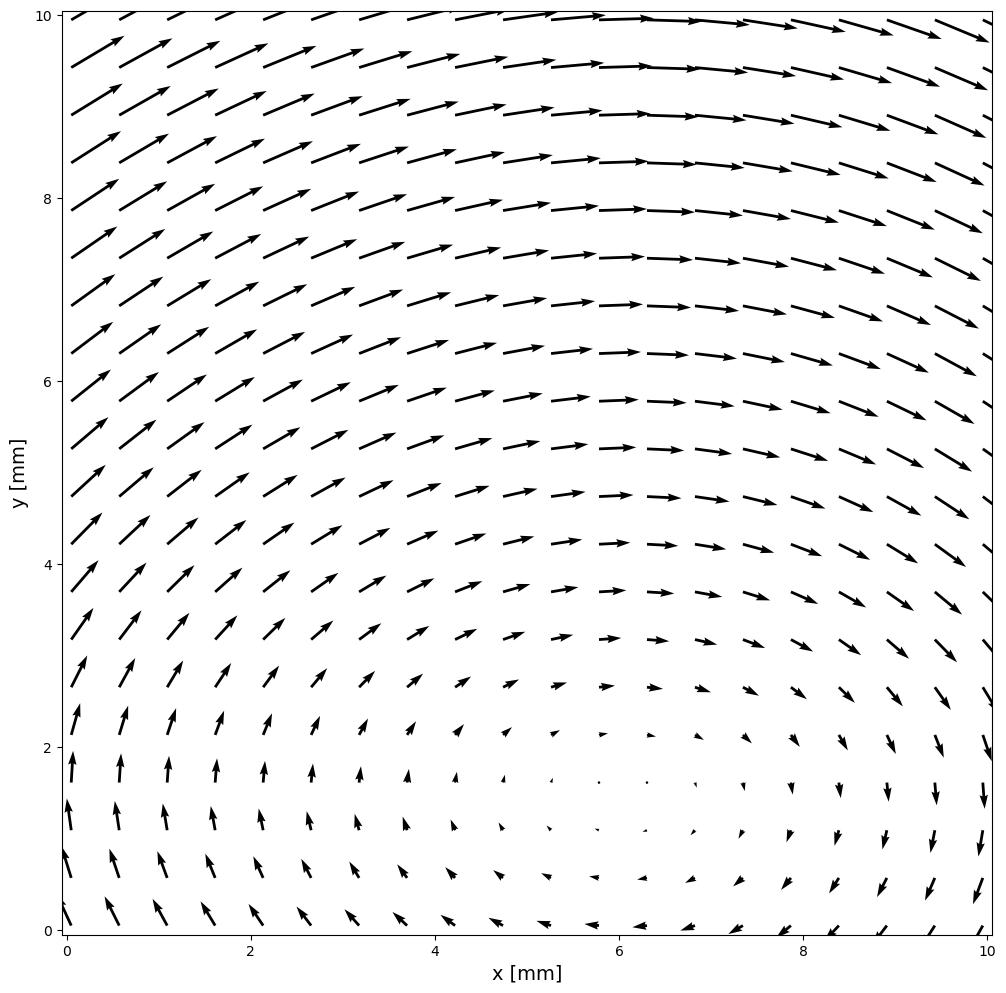

In [21]:
ts = -1 #timestep

thinning = 5 #how much to prune dataset #int
xs, ys = np.linspace(dx/2, lx - dx/2, round(Nx/thinning))*1000, np.linspace(dy/2, ly - dy/2, round(Ny/thinning))*1000
Y, X = np.meshgrid(xs,ys) #why do I have to switch this? The world may never know.
u_c, v_c = centerize(u[ts],v[ts]) #centerize
u_c, v_c = u_c[::thinning,::thinning], v_c[::thinning,::thinning] #thin-out

fig, ax = plt.subplots(figsize = (12,12))
ax.set_xlim([-dx/2*1000,(lx + dx/2)*1000])
ax.set_ylim([-dy/2*1000,(ly + dy/2)*1000])
ax.quiver(X, Y, u_c, v_c, scale = 50)
ax.set_xlabel('x [mm]', fontsize = 14)
ax.set_ylabel('y [mm]', fontsize = 14)
#ax.quiverkey(q, X=0.005, Y=0.005, U=10,label='Quiver key, length = 10', labelpos='E')

plt.show()

# MOVIES

In [120]:
def MoviePlot(u, v, ts):
    fig = plt.figure(figsize = (12,12), num = 1, clear = 'True')
    ax = fig.add_subplot(111)

    fig.text(0.72,0.95, f'Time: {dt*ts:.4f} s', fontsize = 14, fontweight = 'bold')
    
    thinning = 5 #how much to prune dataset #int
    xs, ys = np.linspace(dx/2, lx - dx/2, round(Nx/thinning))*1000, np.linspace(dy/2, ly - dy/2, round(Ny/thinning))*1000
    Y, X = np.meshgrid(xs,ys) #why do I have to switch this? The world may never know.
    u_c, v_c = centerize(u,v) #centerize
    u_c, v_c = u_c[::thinning,::thinning], v_c[::thinning,::thinning] #thin-out
    
    ax.set_xlim([-dx/2*1000,(lx + dx/2)*1000])
    ax.set_ylim([-dy/2*1000,(ly + dy/2)*1000])
    ax.quiver(X, Y, u_c, v_c, scale = 50)
    ax.set_xlabel('x [mm]', fontsize = 14)
    ax.set_ylabel('y [mm]', fontsize = 14)
        
    plt.savefig('Pictures+Movies/MovieDump/frame' + str(ts) + '.png')
    plt.close()

In [ ]:
#save frames from long memory all at once
fps = 3000 #desired frames per second (reproduced approximately)
interval = int(np.ceil(1/fps/dt)) #number of timesteps skipped every frame to approximately reproduce desired fps
ntmod = ntimesteps - ntimesteps%interval #largest number of timesteps that can be evenly divided by the interval
frames = np.linspace(interval, ntmod-interval, int(ntmod/interval), dtype=int) #timesteps to be used as frames. Start at 'interval', not 0, because RunTFM() does not iterate timestep 0

for ts in frames: #plot and save figures at the timesteps in 'frames'
     MoviePlot(u[ts], v[ts], ts)

# MISC

## Set arrays automatically or manually? (answer: 100% automatically)

In [11]:
arr = rng.random((Nx+1,Ny))
np.shape(arr[:,1:])

(101, 99)

In [25]:
@jit(nopython=True)
def cutarray_numpy(arr):
    cutarr = arr[1:][:]
    return cutarr

In [26]:
@jit(nopython=True)
def cutarray_manual(arr):
    shape = np.shape(arr) #get initial shape
    cutarr = np.zeros((shape[0]-1,shape[1])) #init cut arr
    for i in range(shape[0]-1): #fill
        for j in range(shape[1]):
            cutarr[i][j] = arr[i+1][j]
    cutarr = arr[1:][:]
    return cutarr

In [37]:
#%%timeit
cutarr0 = cutarray_numpy(arr)

In [36]:
#%%timeit
cutarr1 = cutarray_manual(arr)

In [40]:
# WAY SLOWER TO DO THIS MANUALLY

In [39]:
np.all(cutarr0 == cutarr1)

True

## Coordinate representation

In [3]:
arr = np.zeros((10,10))
for i in range(len(arr)):
    arr[i] = np.arange(10)
arr2 = np.cumsum(arr,axis = 0)
arr2

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.],
       [ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27.],
       [ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36.],
       [ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.],
       [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.],
       [ 0.,  7., 14., 21., 28., 35., 42., 49., 56., 63.],
       [ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72.],
       [ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81.],
       [ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]])

In [28]:
np.flip(np.swapaxes(arr2,0,1),0) #Cartesian redisplay

array([[ 9., 18., 27., 36., 45., 54., 63., 72., 81., 90.],
       [ 8., 16., 24., 32., 40., 48., 56., 64., 72., 80.],
       [ 7., 14., 21., 28., 35., 42., 49., 56., 63., 70.],
       [ 6., 12., 18., 24., 30., 36., 42., 48., 54., 60.],
       [ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50.],
       [ 4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.],
       [ 3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.],
       [ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

### Summing and Appending

In [14]:
np.cumsum(arr2, axis = 1)

array([[  0.,   1.,   3.,   6.,  10.,  15.,  21.,  28.,  36.,  45.],
       [  0.,   2.,   6.,  12.,  20.,  30.,  42.,  56.,  72.,  90.],
       [  0.,   3.,   9.,  18.,  30.,  45.,  63.,  84., 108., 135.],
       [  0.,   4.,  12.,  24.,  40.,  60.,  84., 112., 144., 180.],
       [  0.,   5.,  15.,  30.,  50.,  75., 105., 140., 180., 225.],
       [  0.,   6.,  18.,  36.,  60.,  90., 126., 168., 216., 270.],
       [  0.,   7.,  21.,  42.,  70., 105., 147., 196., 252., 315.],
       [  0.,   8.,  24.,  48.,  80., 120., 168., 224., 288., 360.],
       [  0.,   9.,  27.,  54.,  90., 135., 189., 252., 324., 405.],
       [  0.,  10.,  30.,  60., 100., 150., 210., 280., 360., 450.]])

In [16]:
np.sum(np.cumsum(arr2, axis = 1), axis = 1)

array([ 165.,  330.,  495.,  660.,  825.,  990., 1155., 1320., 1485.,
       1650.])

In [26]:
np.append([np.arange(3)], np.zeros((3,3)), axis = 0)

array([[0., 1., 2.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [30]:
yarr = np.swapaxes(np.append([np.arange(3)], np.zeros((3,3)), axis = 0),0,1)

In [31]:
np.flip(np.swapaxes(yarr,0,1),0)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 2.]])

## Derivatives

In [62]:
arr = np.zeros((10,10))
for i in range(len(arr)):
    arr[i] = -np.arange(10) - i
arr

array([[  0.,  -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9.],
       [ -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10.],
       [ -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11.],
       [ -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11., -12.],
       [ -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11., -12., -13.],
       [ -5.,  -6.,  -7.,  -8.,  -9., -10., -11., -12., -13., -14.],
       [ -6.,  -7.,  -8.,  -9., -10., -11., -12., -13., -14., -15.],
       [ -7.,  -8.,  -9., -10., -11., -12., -13., -14., -15., -16.],
       [ -8.,  -9., -10., -11., -12., -13., -14., -15., -16., -17.],
       [ -9., -10., -11., -12., -13., -14., -15., -16., -17., -18.]])

In [63]:
xdivc(arr)

ValueError: cannot assign slice from input of different size